# Training and test the final model to classify metabolic diseases

In this notebook we tested the final model (SVC) to classify 5 metabolic diseases: A1A, DIABETE, NALD, MCM, GS. <br>
The model works with a Recursive Feature Elimination which selects the best features (biomarker) in our dataset. <br>
The best hyper-parameters of the SVC model were already selected in a previous grid search.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import compress
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel, RFECV, RFE
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('../../dataset/trainU.csv', sep=',', index_col=0)

In [3]:
df.head()

,TPD52L2,PQBP1,UBC,MSN,TECPR2,HTRA1,TSC2,TFPI2,BRMS1,RNF122,...,TMEM120B,GMPS,STX17,MYO10,DCTN5,ACOT8,DDX41,NUP37,S100A13,DISEASE
DIABETE_80,0.317308,0.524752,0.423841,0.609589,0.038095,0.570313,0.194444,0.259825,0.611940,0.502262,...,0.299145,0.834951,0.678571,0.318898,0.222222,0.287770,0.574713,0.550459,0.481865,DIABETE
MCM_24,0.212228,0.397281,0.387946,0.434344,0.582763,0.377927,0.750613,0.156657,0.670648,0.565605,...,0.836315,0.480588,0.544868,0.512937,0.572418,0.295262,0.444807,0.199677,0.707201,MCM
DIABETE_117,1.000000,0.195577,1.000000,0.484255,0.000000,0.282397,0.432391,1.000000,0.430812,0.085137,...,0.867477,0.670118,0.050938,0.511076,0.000000,0.459641,0.381262,1.000000,0.050781,DIABETE
A1A_39,0.375781,0.000000,0.436904,0.469231,0.247460,0.050300,0.149881,0.233997,0.007119,0.805700,...,0.193024,0.911520,0.851867,0.230744,0.433154,0.191503,0.181347,0.386808,0.069342,A1A
GS_12,0.551092,0.914364,0.293751,0.438265,0.707744,0.818267,0.713636,0.824889,0.382334,0.674181,...,0.000000,0.465992,0.866507,0.867688,0.706209,0.169942,0.448738,0.688865,0.067062,GS


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, DIABETE_80 to A1A_111
Columns: 4421 entries, TPD52L2 to DISEASE
dtypes: float64(4420), object(1)
memory usage: 10.1+ MB


<AxesSubplot:>

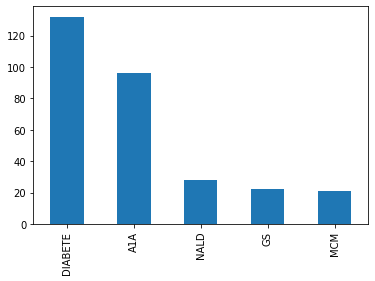

In [5]:
df['DISEASE'].value_counts().plot.bar()

In [6]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']

In [7]:
train_x, val_x, train_y, val_y = train_test_split(df[data_cols], df['DISEASE'], test_size=.25, stratify=df['DISEASE'])

## Feature selection

This feature selection works in steps, reducing the number of features recursively:
   1. Select most important features using feature importances of a random forest classifier
   2. Select from the previous features the most important ones using recursive feature elimination (the best number of features were already selected in previous grid search)

#### Feature importance RandomForest

Optimal number of features : 987


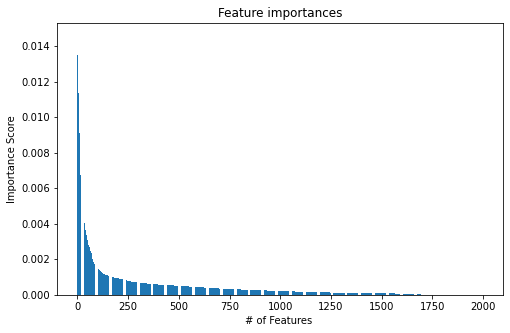

In [8]:
# Use RandomForestClassifier to select most important features

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(train_x, train_y)
model = SelectFromModel(rf_clf, prefit=True)

importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
indices = indices[:2000]
print('Optimal number of features :', model.get_support().sum())

plt.figure(1, figsize=(8, 5))
plt.title("Feature importances")
plt.xlabel("# of Features ")
plt.ylabel("Importance Score")
plt.bar(range(2000), importances[indices])
plt.show()

In [9]:
rf_cols = list(compress(data_cols, model.get_support()))

#### Recursive Feature Elimination

In [10]:
n_features = 283

In [11]:
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=n_features, step=5)
rfe = rfe.fit(train_x[rf_cols], train_y)

In [12]:
rfe_cols = list(compress(train_x[rf_cols].columns, rfe.get_support()))

In [13]:
train_x, val_x, train_y, val_y = train_x[rfe_cols], val_x[rfe_cols], train_y, val_y

In [14]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, DIABETE_126 to DIABETE_88
Columns: 283 entries, PQBP1 to PPIC
dtypes: float64(283)
memory usage: 497.0+ KB


In [15]:
val_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75 entries, DIABETE_20 to A1A_3
Columns: 283 entries, PQBP1 to PPIC
dtypes: float64(283)
memory usage: 166.4+ KB


## Train SVC

In [16]:
best_params = {'C': 4.3,
               'class_weight': 'balanced',
               'coef0': 1.9, 'degree': 2,
               'gamma': 'scale',
               'kernel': 'poly',
               'shrinking': True}

In [17]:
clf = SVC(**best_params)
clf.fit(train_x, train_y)

SVC(C=4.3, class_weight='balanced', coef0=1.9, degree=2, kernel='poly')

In [18]:
clf.score(train_x, train_y)

1.0

In [19]:
print(classification_report(val_y, clf.predict(val_x)))

              precision    recall  f1-score   support

         A1A       1.00      1.00      1.00        24
     DIABETE       0.94      0.91      0.92        33
          GS       0.75      1.00      0.86         6
         MCM       1.00      1.00      1.00         5
        NALD       0.83      0.71      0.77         7

    accuracy                           0.93        75
   macro avg       0.90      0.92      0.91        75
weighted avg       0.94      0.93      0.93        75



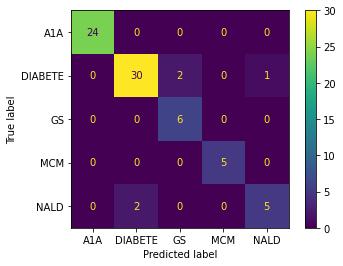

In [31]:
ConfusionMatrixDisplay.from_estimator(clf, val_x, val_y)

## Test SVC

In [21]:
test = pd.read_csv('../../dataset/testU.csv', sep=',', index_col=0)

In [22]:
test.head()

,TPD52L2,PQBP1,UBC,MSN,TECPR2,HTRA1,TSC2,TFPI2,BRMS1,RNF122,...,TMEM120B,GMPS,STX17,MYO10,DCTN5,ACOT8,DDX41,NUP37,S100A13,DISEASE
DIABETE_107,0.480062,0.331089,0.559612,0.145919,0.552987,0.928214,1.000000,0.627466,0.777439,0.377028,...,0.160809,0.330324,0.039148,0.612082,0.301108,0.424032,0.534618,0.374668,0.157539,DIABETE
DIABETE_89,0.663462,0.841584,0.907285,0.472603,0.771429,0.218750,0.784722,0.471616,0.917910,0.285068,...,0.982906,0.368932,0.190476,0.527559,0.802469,0.618705,0.781609,0.688073,1.000000,DIABETE
A1A_2,0.522464,0.243671,0.503386,0.225593,0.133470,0.430692,0.343143,0.059188,0.332863,0.217627,...,0.711604,0.694920,0.580323,0.322831,0.278889,0.226221,0.203807,0.363662,0.083471,A1A
GS_23,0.569581,0.761194,0.232405,0.461864,0.120214,0.990555,0.434700,0.637531,0.837640,0.880204,...,0.349635,0.462027,0.530053,0.717613,0.159534,0.697094,0.328126,0.597554,0.441224,GS
MCM_15,0.193595,0.603720,0.578065,0.000000,0.159841,0.970036,0.948340,0.258584,0.132309,0.816709,...,0.103328,0.622793,0.489486,0.294818,0.693985,0.397131,1.000000,0.142732,0.653312,MCM


In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, DIABETE_107 to DIABETE_62
Columns: 4421 entries, TPD52L2 to DISEASE
dtypes: float64(4420), object(1)
memory usage: 3.4+ MB


<AxesSubplot:>

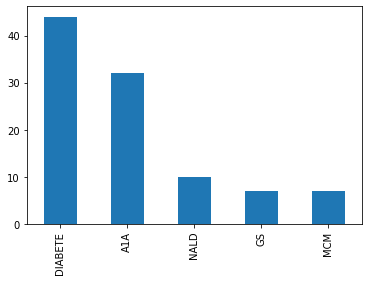

In [24]:
test['DISEASE'].value_counts().plot.bar()

In [25]:
data_cols = [col_name for col_name in test.columns if col_name != 'DISEASE']

In [26]:
test_x, test_y = test[data_cols], test['DISEASE']

In [27]:
# Apply feature selection to test set
test_x, test_y = test[rfe_cols], test_y

In [28]:
print(classification_report(test_y, clf.predict(test_x)))

              precision    recall  f1-score   support

         A1A       0.94      0.94      0.94        32
     DIABETE       0.83      0.91      0.87        44
          GS       1.00      1.00      1.00         7
         MCM       1.00      1.00      1.00         7
        NALD       0.67      0.40      0.50        10

    accuracy                           0.88       100
   macro avg       0.89      0.85      0.86       100
weighted avg       0.87      0.88      0.87       100



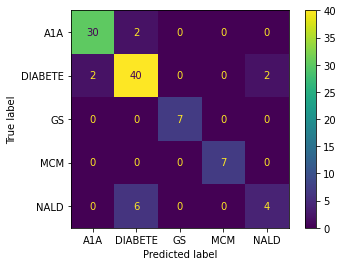

In [32]:
ConfusionMatrixDisplay.from_estimator(clf, test_x, test_y)